In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##### Set up the model parameters and initial conditions #####

# Model parameters
Radius_Plate = 50  # mm
Radius_Disk = 3  # mm
T = 24 * 60  # min
D = 0.05  # uM^2/min
dAHL = 0.0002  # uM/min
sourceconc = 10  # uM

# X-Y Mesh
num_pts = 401
dp = 60 / (num_pts - 1)
dx = dp
dy = dp

xgrid = np.linspace(-Radius_Plate, Radius_Plate, num_pts)  # centers the grid in x around zero
ygrid = np.linspace(-Radius_Plate, Radius_Plate, num_pts)  # centers the grid in y around zero
X, Y = np.meshgrid(xgrid, ygrid)  # creates the matrix that describes the mesh using meshgrid

# Discretize time
stability_factor = 0.1  # must be <= 0.25 for FTCS in 2D
dt = stability_factor * (dp ** 2) / D  # (min) time increment that fulfills the stability criterion
time = np.arange(0, T + dt, dt)  # Time Vector incremented in steps of dt
print(max(time)/60)

# Setting initial values
AHL_Initial = np.zeros((len(xgrid), len(ygrid)))  # Set initial AHL concentration to zero
# Set the initial concentration of the disk
Disk_Indices = np.sqrt(X ** 2 + Y ** 2) <= Radius_Disk
AHL_Initial[Disk_Indices] = sourceconc

print(dp)
print(dt)

24.000749999999993
0.15
0.04499999999999999


In [199]:
#### DEFINE COMMON FUNCTIONS ####

def fd_model_single_iteration(curr_concs, C_AHL, C_LuxR, K_R, dt):
    # Extracting each concentration component
    C_R, C_TXGFP, C_GFP = curr_concs[:,:,0], curr_concs[:,:,1], curr_concs[:,:,2]
    
    # Define parameters (example values, adjust as necessary)
    alp_TXGFP = 0.05 # No change
    rho_R = 0.5 # No change
    del_TXGFP = 0.2 # No change
    del_R = 7.91e-6
    alp_GFP = 2 # No change
    del_GFP = 0.0004 # No change
    n = 1             # Hill coefficient
    
    # Reaction dynamics equations
    dRdt = rho_R * (C_LuxR**2) * (C_AHL**2) / (del_R * K_R) - del_R * C_R
    dTXGFPdt = (alp_TXGFP * (C_R / K_R)**n) / (1 + (C_R / K_R)**n) - del_TXGFP * C_TXGFP
    dGFPdt = alp_GFP * C_TXGFP - del_GFP * C_GFP
    
    # Returning the differential concentrations as a matrix similar to input format
    dconcs = np.stack((dRdt, dTXGFPdt, dGFPdt), axis=2) * dt
    
    return dconcs

def diffuse_2d(AHL, D, dAHL):
    r = D * dt / (dp ** 2)  # r term in the Finite Difference Equation

    # Calculate diffusion using matrix operations
    AHL_padded = np.pad(AHL, 1, mode='constant')  # Pad the matrix with zeros

    # Shift AFL in all directions
    AHL_up = AHL_padded[:-2, 1:-1]
    AHL_down = AHL_padded[2:, 1:-1]
    AHL_left = AHL_padded[1:-1, :-2]
    AHL_right = AHL_padded[1:-1, 2:]

    # Calculate diffusion
    AHL = AHL + r * (AHL_up + AHL_down + AHL_left + AHL_right - 4 * AHL) - dAHL * AHL * dt

    # Set center disk as infinite source (all in disk indices)
    # AHL[center_index, center_index] = sourceconc
    AHL[Disk_Indices] = sourceconc

    # Set edges as infinite sink
    AHL[0, :] = 0
    AHL[-1, :] = 0
    AHL[:, 0] = 0
    AHL[:, -1] = 0

    return AHL

def findEdge(concentration_profile, switch_point, xgrid):
    """
    Finds the edge distance for a given concentration profile and switch point.
    Only consider the first half of the profile.
    """
    # Find first index where concentration is above the switch point, starting from the outside and going to the center
    idx = 0
    for i in range(len(concentration_profile)//2):
        if concentration_profile[i] > switch_point:
            idx = i
            break

    # Return the distance from the center of the plate to the edge, considering that the grid is centered around zero
    return np.abs(xgrid[idx])

def findGFPEdge(concentration_profile, xgrid):
    # Find maximum GFP concentration
    max_idx = np.argmax(concentration_profile)

    # Find first indecx where conc. is < 50% of max conc., starting from the center and going outwards
    idx = 0
    for i in range(max_idx, len(concentration_profile)):
        if concentration_profile[i] < 0.8 * concentration_profile[max_idx]:
            idx = i
            break

    # Return the distance from the center of the plate to the edge, considering that the grid is centered around zero
    return np.abs(xgrid[idx])

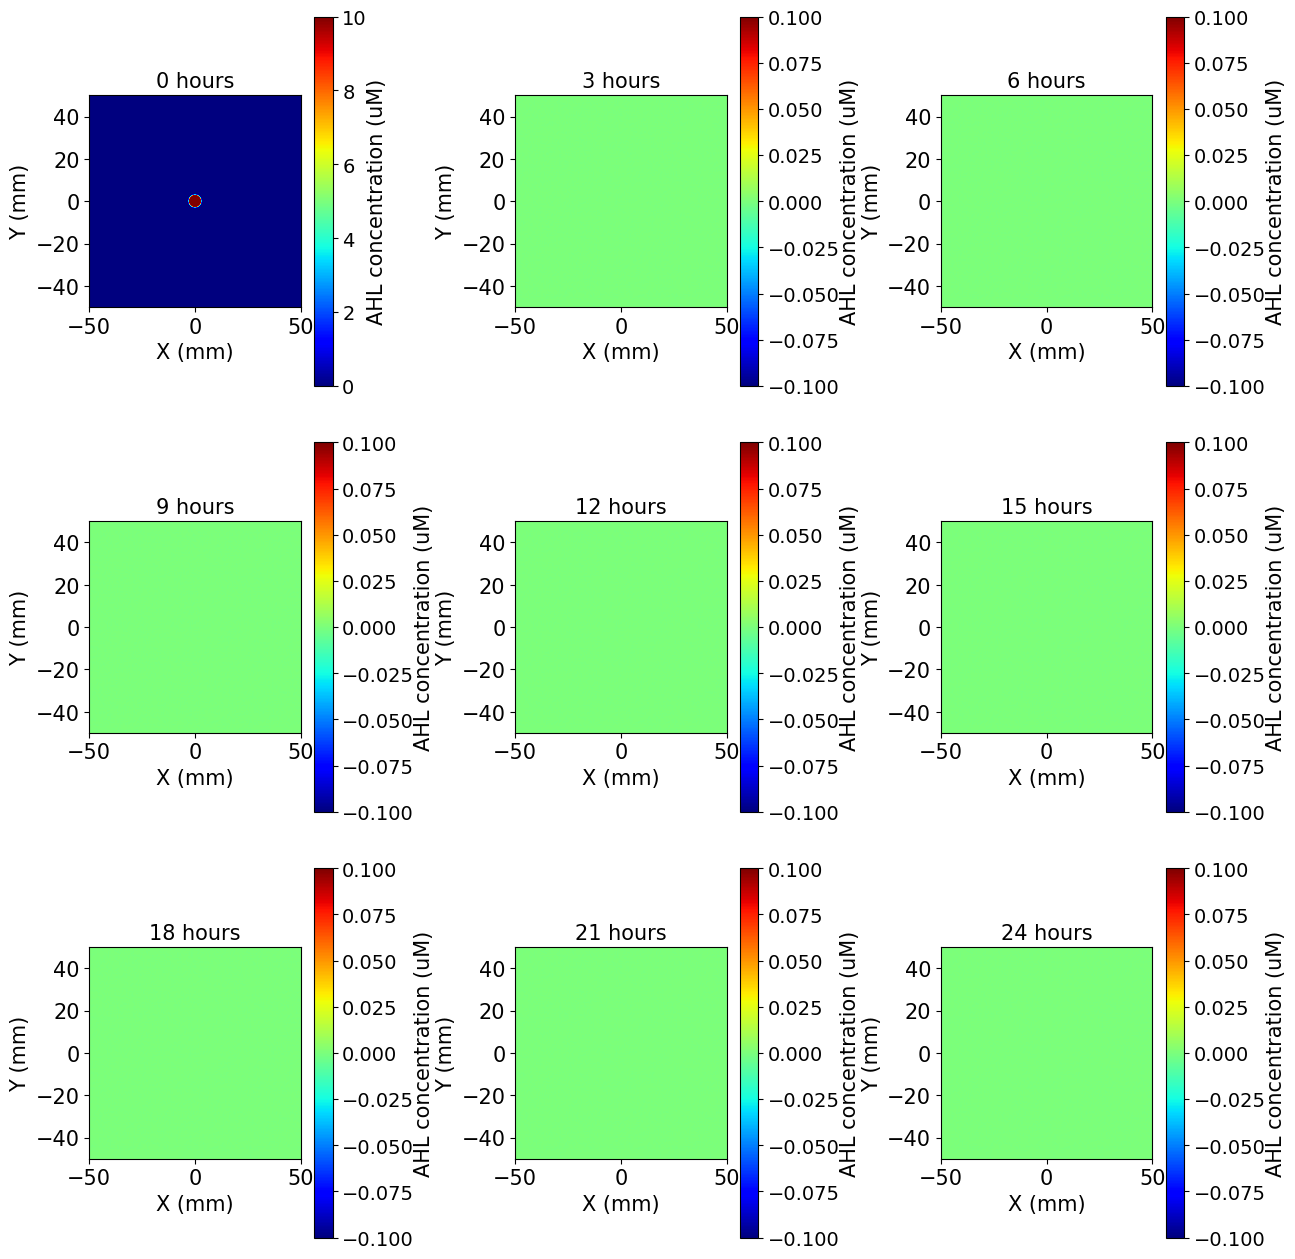

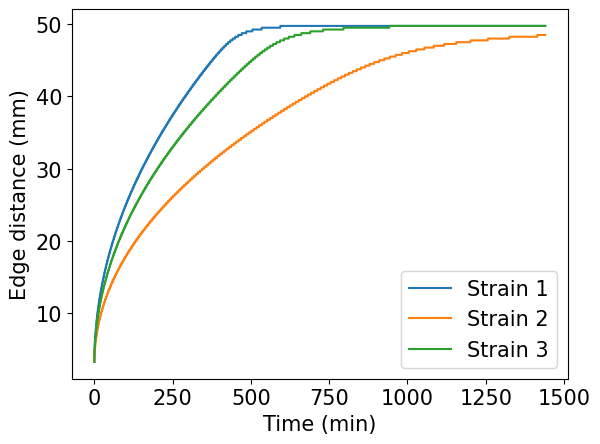

In [200]:
#### PLOT THE AHL CONCENTRATION OVER TIME ####

# Plot the edge distances over time for all 3 strains
AHL = np.copy(AHL_Initial)

switch_points = [9.102981779915228e-05, 0.017575106248547894 , 0.000868511373751352  ]
center_index = len(xgrid) // 2
edge_distances = np.zeros((3, len(time)))

# Save AHL every 3 hours
AHL_3h = np.zeros((len(time)//(3*60), len(xgrid), len(ygrid)))

for i, t in enumerate(time):
    # Calculate diffusion using matrix operations
    AHL = diffuse_2d(AHL, D, dAHL)

    # Every multiple of 3 hours, save the AHL concentration
    if (t % (3*60) == 0):
        AHL_3h[int(t/(3*60))] = AHL

    # Find edge distances for each strain
    edge_distances[0, i] = findEdge(AHL[center_index, :], switch_points[0], xgrid)
    edge_distances[1, i] = findEdge(AHL[center_index, :], switch_points[1], xgrid)
    edge_distances[2, i] = findEdge(AHL[center_index, :], switch_points[2], xgrid)

# Plot the AHL concentrations as a heatmap every 3 hrs in 3x3 grid
fontsize = 15
# set all fonts to font size as default
plt.rcParams.update({'font.size': fontsize})
fig, axs = plt.subplots(3, 3, figsize=(13, 13))
ctr = 0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(AHL_3h[i*3+j], cmap='jet', extent=[-50, 50, -50, 50])
        axs[i, j].set_title(f'{ctr} hours')
        ctr += 3
        axs[i, j].set_xlabel('X (mm)')
        axs[i, j].set_ylabel('Y (mm)')
        # Add a colorbar to each plot
        cbar = axs[i, j].figure.colorbar(axs[i, j].imshow(AHL_3h[i*3+j], cmap='jet', extent=[-50, 50, -50, 50]), ax=axs[i, j])
        # Increase the font size of the all the labels
        cbar.ax.tick_params(labelsize=14)
        # Increase the font size of the colorbar title, put it sideways
        cbar.ax.set_ylabel('AHL concentration (uM)', rotation=90, fontsize=fontsize, labelpad=0)
        # Increase font size of axis labels
        axs[i, j].xaxis.label.set_size(fontsize)
        axs[i, j].yaxis.label.set_size(fontsize)
        # Increase font size of ticks
        axs[i, j].xaxis.label.set_size(fontsize)
        axs[i, j].yaxis.label.set_size(fontsize)
        # Increa size of title
        axs[i, j].title.set_size(fontsize)
plt.tight_layout()
plt.show()

# Plot the edge distances over time
plt.figure()
plt.plot(time, edge_distances[0], label='Strain 1')
plt.plot(time, edge_distances[1], label='Strain 2')
plt.plot(time, edge_distances[2], label='Strain 3')
plt.xlabel('Time (min)')
plt.ylabel('Edge distance (mm)')
plt.legend()
plt.show()

Number of frames: 10


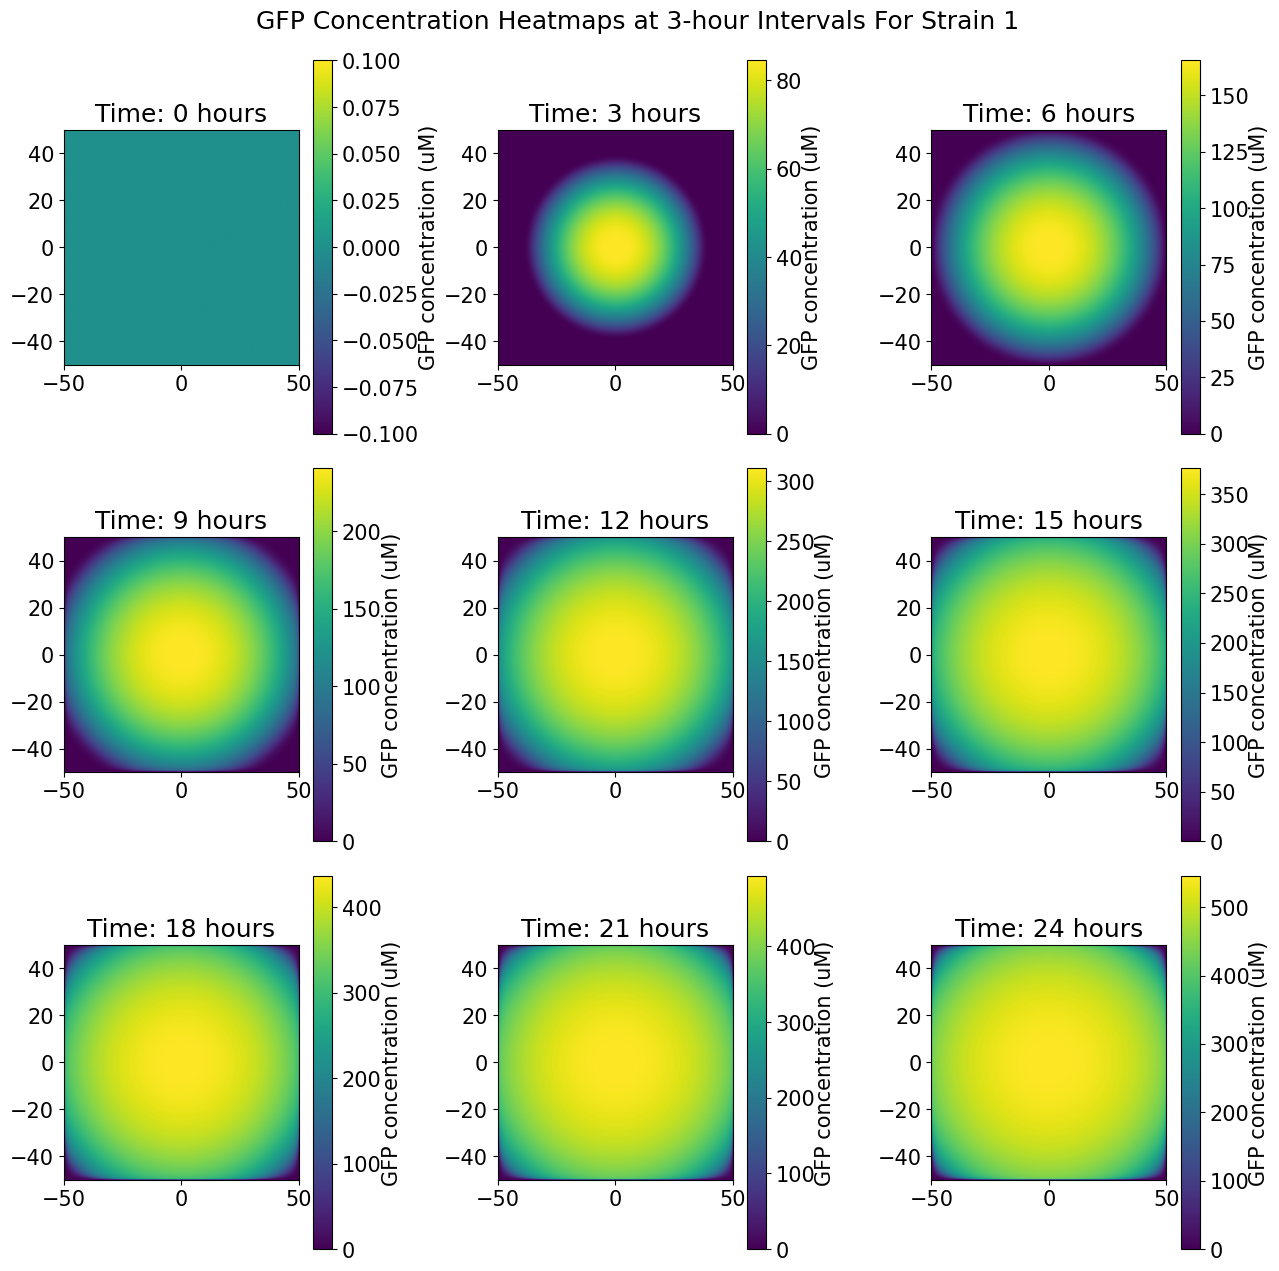

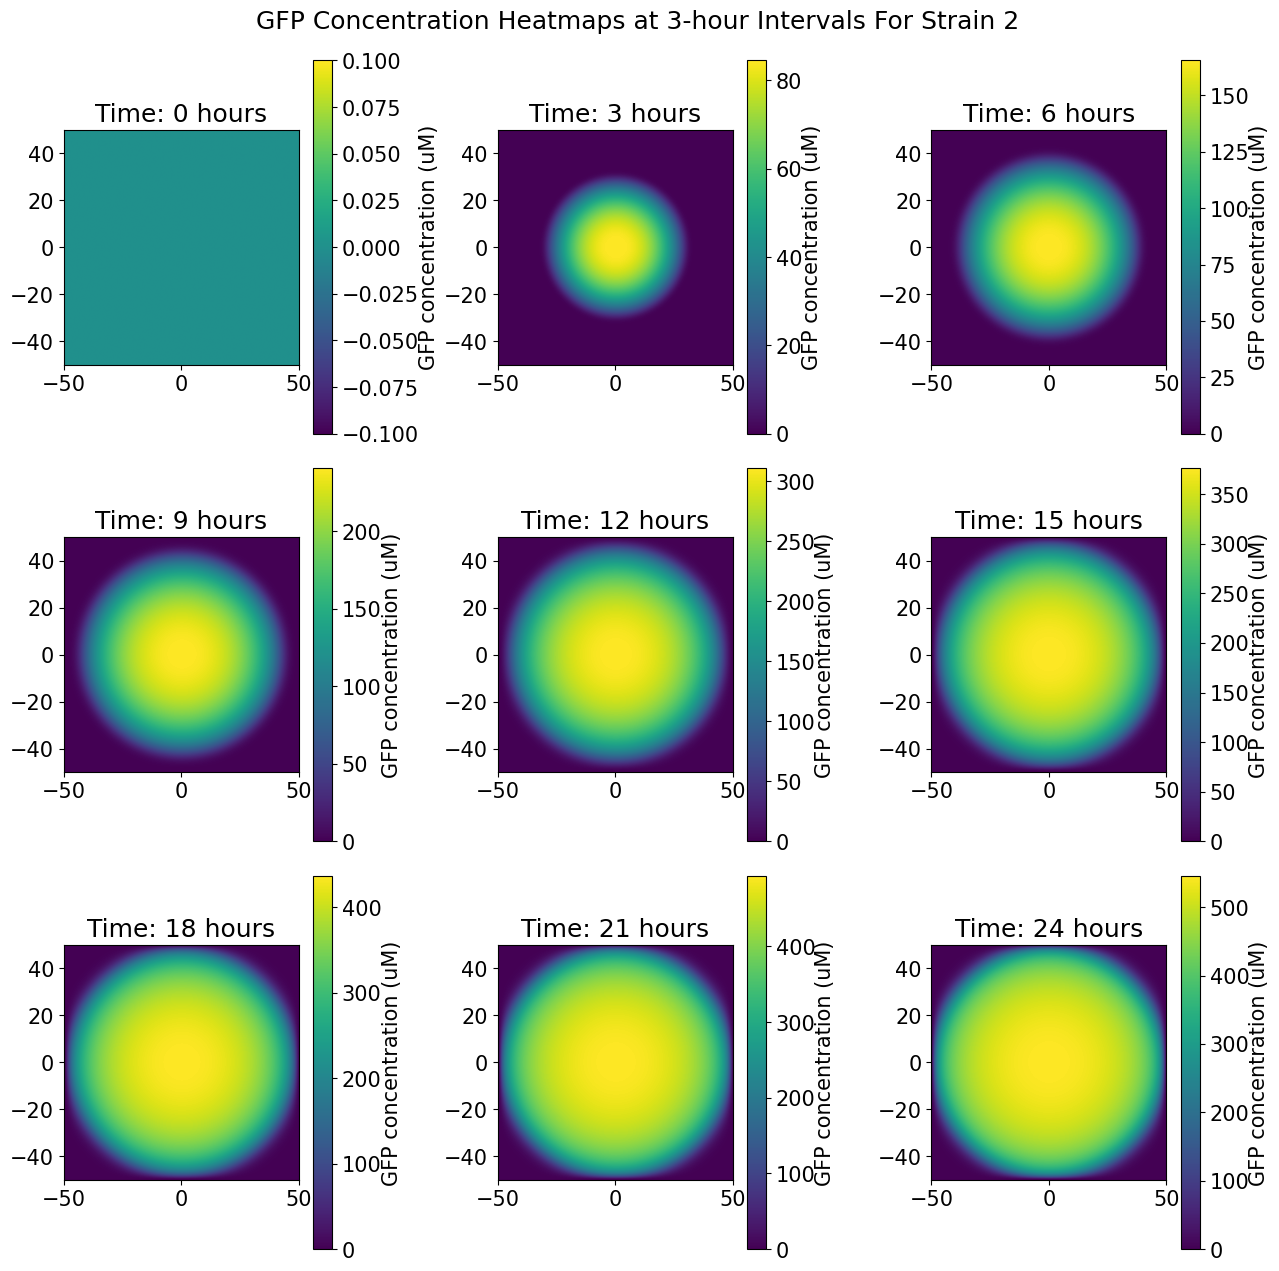

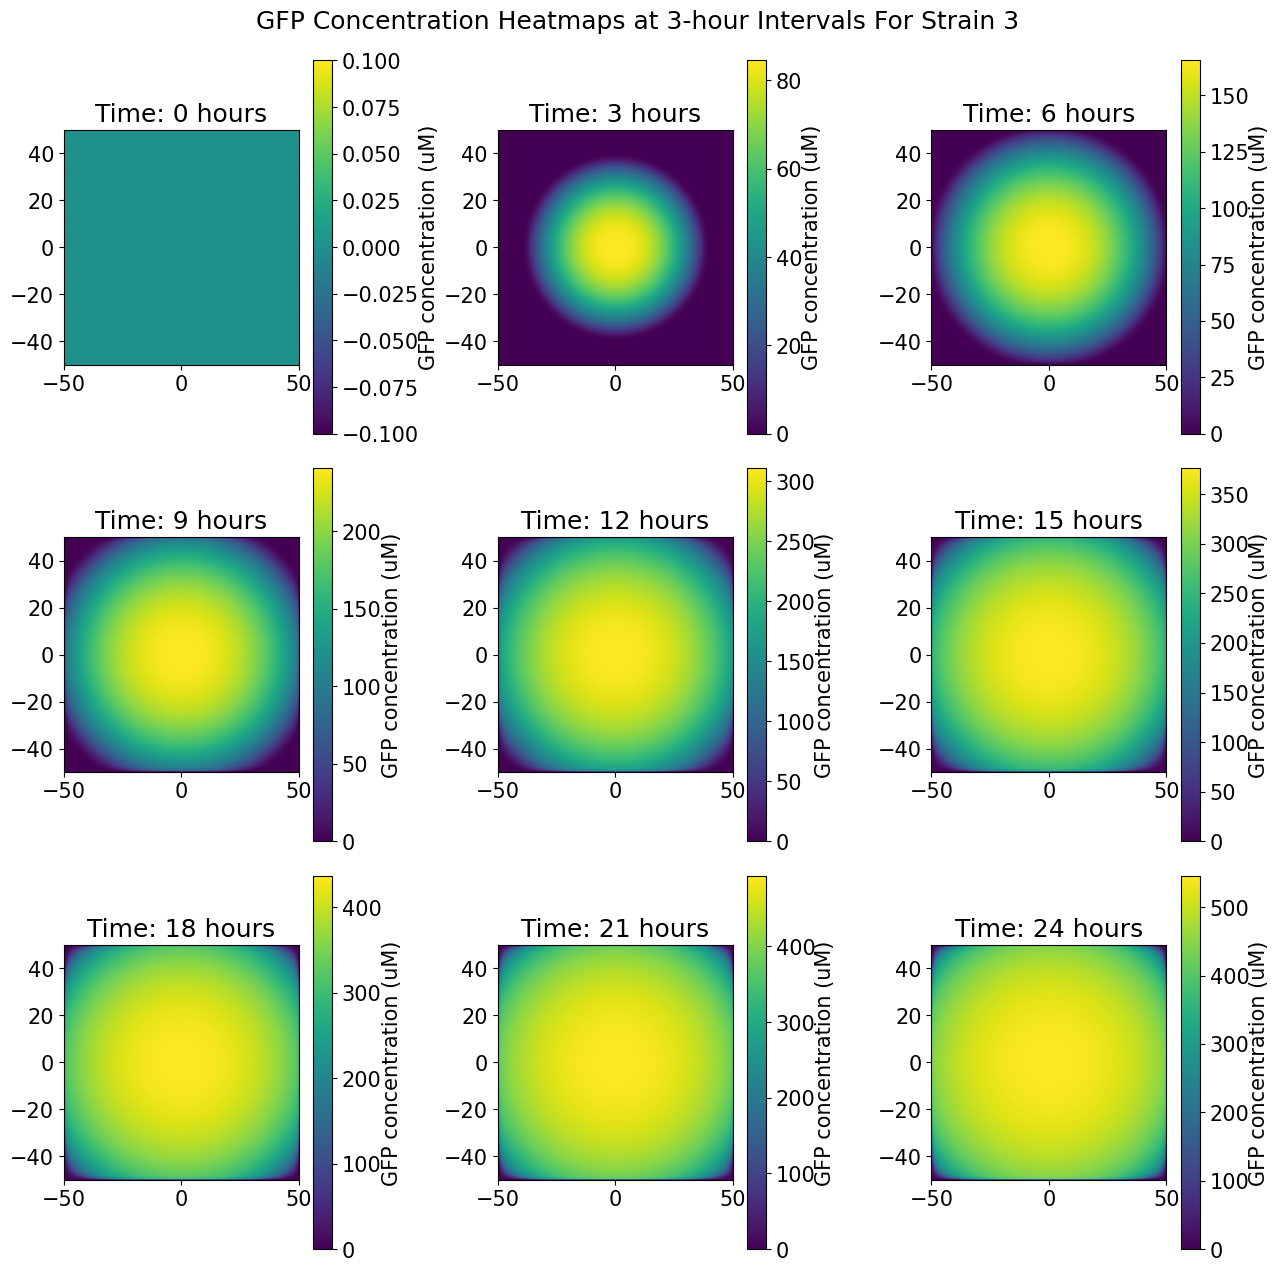

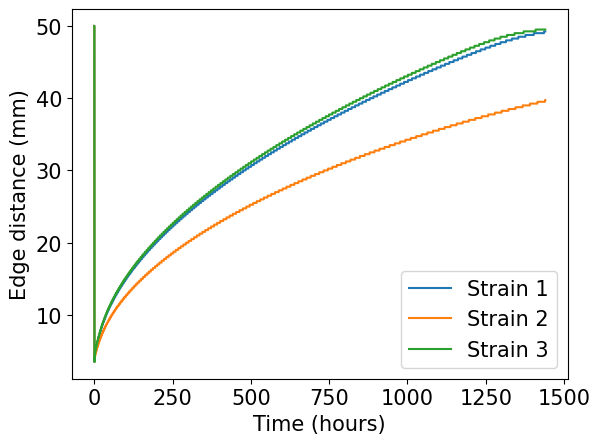

In [201]:
######### SIMULATE THE STRAINS, SHOW GFP OVER TIME #########
# Calculate number of frames based on 3-hour intervals
totalTime = time[-1]  # Get the total simulation time in minutes
interval = 180  # 3 hours in minutes
numFrames = int(np.ceil(totalTime / interval) + 1)  # Number of frames to save
print(f'Number of frames: {numFrames}')

def model_2d_diffusion(AHL, D, dAHL, withreturn=False):
    # Simulation with non-steady state diffeqs
    R = np.zeros(AHL_Initial.shape)
    TXGFP = np.zeros(AHL_Initial.shape)
    GFP = np.zeros(AHL_Initial.shape)
    curr_concs_1 = np.stack((R, TXGFP, GFP), axis=2)  # Now curr_concs[:,:,0] is R, curr_concs[:,:,1] is TXGFP, etc.
    curr_concs_2 = np.copy(curr_concs_1)
    curr_concs_3 = np.copy(curr_concs_1)

    # Calculate number of frames based on 3-hour intervals
    totalTime = time[-1]  # Get the total simulation time in minutes
    interval = 180  # 3 hours in minutes
    numFrames = int(np.ceil(totalTime / interval) + 1)  # Number of frames to save

    c_LUXR_1 = 0.368
    c_LUXR_23 = 0.00249
    k_R_12 = 8.94e-5
    k_R_3 = 3.63e-7

    m, n = GFP.shape

    # Initialization of allGFP
    allGFP_1 = np.zeros((m, n, numFrames))
    allGFP_2 = np.zeros((m, n, numFrames))
    allGFP_3 = np.zeros((m, n, numFrames))

    # Track edge distances over time
    edge_distances_GFP = np.zeros((3, len(time)))

    # Variables to track saving frames
    saveInterval = int(interval / dt)  # Number of time steps between saves
    frameIndex = 0  # Index for allGFP

    for t_idx, t in enumerate(time):
        # Calculate diffusion using matrix operations
        AHL = diffuse_2d(AHL, D, dAHL)
        
        # Update other matrices
        dconcs = fd_model_single_iteration(curr_concs_1, AHL, c_LUXR_1, k_R_12, dt)
        curr_concs_1 += dconcs  # Update concentrations
        dconcs = fd_model_single_iteration(curr_concs_2, AHL, c_LUXR_23, k_R_12, dt)
        curr_concs_2 += dconcs  # Update concentrations
        dconcs = fd_model_single_iteration(curr_concs_3, AHL, c_LUXR_23, k_R_3, dt)
        curr_concs_3 += dconcs  # Update concentrations

        # Update edge distances
        edge_distances_GFP[0, t_idx] = findGFPEdge(curr_concs_1[:, center_index, 2], xgrid)
        edge_distances_GFP[1, t_idx] = findGFPEdge(curr_concs_2[:, center_index, 2], xgrid)
        edge_distances_GFP[2, t_idx] = findGFPEdge(curr_concs_3[:, center_index, 2], xgrid)
        
        # Check if current time step corresponds to a 3-hour interval
        if t_idx % saveInterval == 0:
            allGFP_1[:, :, frameIndex] = curr_concs_1[:, :, 2]
            allGFP_2[:, :, frameIndex] = curr_concs_2[:, :, 2]
            allGFP_3[:, :, frameIndex] = curr_concs_3[:, :, 2]
            frameIndex += 1
    
    if withreturn:
        return allGFP_1, allGFP_2, allGFP_3, edge_distances_GFP
    else:
        return edge_distances_GFP

# Run the model
allGFP_1, allGFP_2, allGFP_3, edge_distances_GFP = model_2d_diffusion(AHL_Initial, D, 0.01, withreturn=True)

# Plotting 
plt.figure(figsize=(13, 13))
for frameIdx in range(9):
    plt.subplot(3, 3, frameIdx + 1) 
    # Plot logscale heatmap
    plt.imshow(allGFP_1[:, :, frameIdx], cmap='viridis', extent=[-50, 50, -50, 50])  # Plot heatmap
    cbar = plt.colorbar()  # Show color scale
    cbar.ax.set_ylabel('GFP concentration (uM)', rotation=90, fontsize=fontsize, labelpad=0)
    plt.title(f'Time: {frameIdx * 3} hours') 
plt.suptitle('GFP Concentration Heatmaps at 3-hour Intervals For Strain 1')  # Super title for the entire figure
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 13))
for frameIdx in range(9):
    plt.subplot(3, 3, frameIdx + 1) 
    plt.imshow(allGFP_2[:, :, frameIdx], cmap='viridis', extent=[-50, 50, -50, 50])  # Plot heatmap
    cbar = plt.colorbar()  # Show color scale
    cbar.ax.set_ylabel('GFP concentration (uM)', rotation=90, fontsize=fontsize, labelpad=0)
    plt.title(f'Time: {frameIdx * 3} hours')
plt.suptitle('GFP Concentration Heatmaps at 3-hour Intervals For Strain 2')  # Super title for the entire figure
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 13))
for frameIdx in range(9):
    plt.subplot(3, 3, frameIdx + 1) 
    plt.imshow(allGFP_3[:, :, frameIdx], cmap='viridis', extent=[-50, 50, -50, 50])  # Plot heatmap
    cbar = plt.colorbar()  # Show color scale
    cbar.ax.set_ylabel('GFP concentration (uM)', rotation=90, fontsize=fontsize, labelpad=0)
    plt.title(f'Time: {frameIdx * 3} hours')
plt.suptitle('GFP Concentration Heatmaps at 3-hour Intervals For Strain 3')  # Super title for the entire figure
plt.tight_layout()
plt.show()

# Plot GFP edge distances over time
plt.figure()
plt.plot(time, edge_distances_GFP[0], label='Strain 1')
plt.plot(time, edge_distances_GFP[1], label='Strain 2')
plt.plot(time, edge_distances_GFP[2], label='Strain 3')
plt.xlabel('Time (hours)')
plt.ylabel('Edge distance (mm)')
plt.legend()
plt.show()


Avg std for 1s: 1.958600657311589
Avg std for 2s: 2.9061731428580493
Avg std for p5s: 4.603491024311593
Avg std for 1s: 8.445654377795815
Avg std for 2s: 10.893430790724382
Avg std for p5s: 6.534381383868347
Avg std for 1s: 4.572069935643572
Avg std for 2s: 8.01417545053735
Avg std for p5s: 6.844776394124383
got exp_data_1
got exp_data_2
got exp_data_3


C:\Users\ckywu\AppData\Local\Temp\ipykernel_29992\1071768449.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data_3['Radius (mm)'] = exp_data_3[col_name] / 2


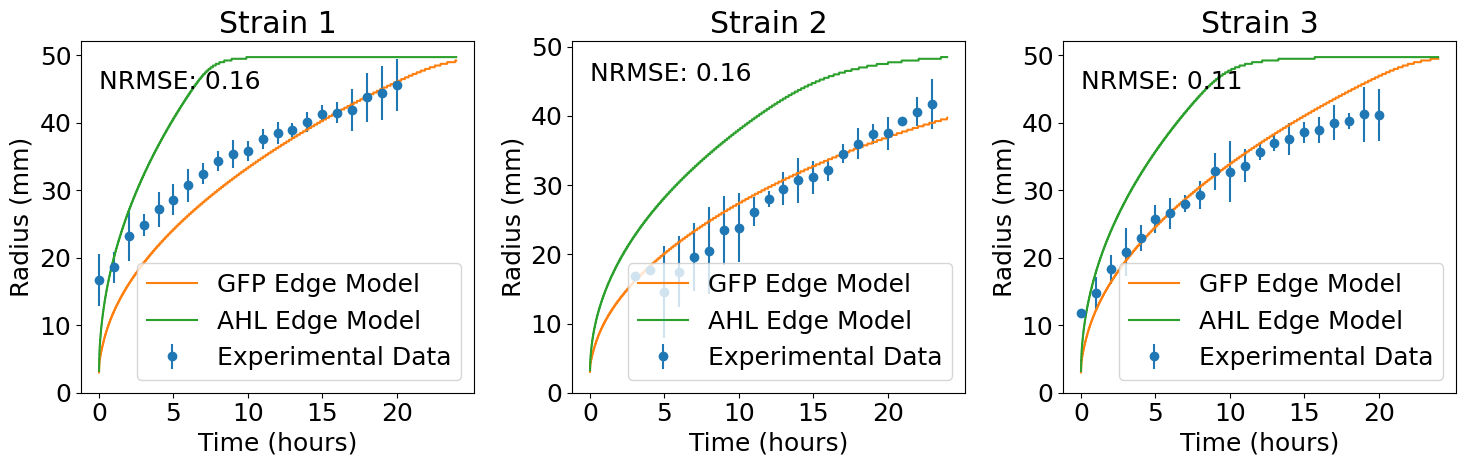

In [202]:
#### COMPARE MODEL TO EXPERIMENTAL DATA ####

# Load experimental data from '"Image Analysis - Strain 1 Reformatted.csv"'
exp_data_1 = pd.read_csv('Image Analysis - Strain 1 Reformatted (1).csv')
exp_data_2 = pd.read_csv('Image Analysis - Strain 2 Reformatted.csv')
exp_data_3 = pd.read_csv('Image Analysis - Strain 3 Reformatted.csv')

# For each strain compare the avg variances in edge distances for 1s, 2s, and p5s
for data in [exp_data_1, exp_data_2, exp_data_3]:
    # Get the 3 diameter columns (convert to numeric first)
    col1 = pd.to_numeric(data['Diameter (mm), 1s'], errors='coerce')
    col2 = pd.to_numeric(data['Diameter (mm), 2s'], errors='coerce')
    col3 = pd.to_numeric(data['Diameter (mm), p5s'], errors='coerce')

    # Groupby time and get the std for each time point
    std1 = col1.groupby(data['Time (hours)']).std()
    std2 = col2.groupby(data['Time (hours)']).std()
    std3 = col3.groupby(data['Time (hours)']).std()

    # Print the avg std for each column
    print(f'Avg std for 1s: {std1.mean()}')
    print(f'Avg std for 2s: {std2.mean()}')
    print(f'Avg std for p5s: {std3.mean()}')

col_name = 'Diameter (mm), 1s'
col_name2 = 'Diameter (mm), p5s'

# Convert to numeric
exp_data_1[col_name2] = pd.to_numeric(exp_data_1[col_name2], errors='coerce')
exp_data_2[col_name2] = pd.to_numeric(exp_data_2[col_name2], errors='coerce')
exp_data_3[col_name] = pd.to_numeric(exp_data_3[col_name], errors='coerce')
exp_data_1['Time (hours)'] = pd.to_numeric(exp_data_1['Time (hours)'], errors='coerce')
exp_data_2['Time (hours)'] = pd.to_numeric(exp_data_2['Time (hours)'], errors='coerce')
exp_data_3['Time (hours)'] = pd.to_numeric(exp_data_3['Time (hours)'], errors='coerce')

#  Drop NaN values
exp_data_1 = exp_data_1.dropna()
exp_data_2 = exp_data_2.dropna()
exp_data_3 = exp_data_3.dropna()

# Get the "Diameter (mm), p5s" column and convert to radius
exp_data_1['Radius (mm)'] = exp_data_1[col_name2] / 2
exp_data_2['Radius (mm)'] = exp_data_2[col_name2] / 2
exp_data_3['Radius (mm)'] = exp_data_3[col_name] / 2

# Average all the data for each time point + get stdev
exp_data_1 = exp_data_1.groupby('Time (hours)').agg(['mean', 'std'])
print("got exp_data_1")
exp_data_2 = exp_data_2.groupby('Time (hours)').agg(['mean', 'std'])
print("got exp_data_2")
exp_data_3 = exp_data_3.groupby('Time (hours)').agg(['mean', 'std'])
print("got exp_data_3")

graphed_time = time / 60

def get_nrmse(edge_distances_GFP):
    # Change leading outliers to radius
    for i in range(len(edge_distances_GFP)):
        for j in range(len(edge_distances_GFP[i])//10):
            if edge_distances_GFP[i][j] >= Radius_Plate:
                edge_distances_GFP[i][j] = Radius_Disk

    # Get the list of modeled gfp edge distances corresponding to the experimental time points
    # Convert time to hours
    compared_distances = np.zeros((3, len(exp_data_1.index)))

    # Get the closest time point in the model to each experimental time point
    for i, t in enumerate(exp_data_1.index):
        idx = np.argmin(np.abs(graphed_time - t))
        compared_distances[0, i] = edge_distances_GFP[0][idx]
        compared_distances[1, i] = edge_distances_GFP[1][idx]
        compared_distances[2, i] = edge_distances_GFP[2][idx]

    # Get nrmses
    def nrmse(y, y_pred):
        return np.sqrt(np.mean((y - y_pred)**2)) / (y.max() - y.min())
    nrmses = np.zeros(3)
    nrmses[0] = nrmse(exp_data_1['Radius (mm)']['mean'], compared_distances[0])
    nrmses[1] = nrmse(exp_data_2['Radius (mm)']['mean'], compared_distances[1])
    nrmses[2] = nrmse(exp_data_3['Radius (mm)']['mean'], compared_distances[2])

    return nrmses

nrmses = get_nrmse(edge_distances_GFP)

# graphed_time = graphed_time[graphed_time <= 21]

# Plot the experimental data as radius vs time and the GFP edge distance for s1 (3 subplots, one for each strain)
plt.figure(figsize=(15, 5))
# Set font size for all plots
plt.rcParams.update({'font.size': 18})
plt.subplot(1, 3, 1)
# Plot the experimental data as mean + stdev error bars
plt.errorbar(
    exp_data_1.index, 
    exp_data_1['Radius (mm)']['mean'], 
    yerr=exp_data_1['Radius (mm)']['std'], 
    fmt='o',
    label='Experimental Data')
plt.plot(graphed_time, edge_distances_GFP[0][:len(graphed_time)], label='GFP Edge Model')
plt.plot(graphed_time, edge_distances[0][:len(graphed_time)], label='AHL Edge Model')
plt.text(1e-5, 45, 'NRMSE: ' + str(round(nrmses[0], 2)))
plt.xlabel('Time (hours)')
plt.ylabel('Radius (mm)')
plt.yticks(np.arange(0, 59, 10))
plt.xticks(np.arange(0, 21, 5))
plt.title('Strain 1')
plt.legend()

plt.subplot(1, 3, 2)
# Plot the experimental data as mean + stdev error bars
plt.errorbar(
    exp_data_2.index, 
    exp_data_2['Radius (mm)']['mean'], 
    yerr=exp_data_2['Radius (mm)']['std'], 
    fmt='o',
    label='Experimental Data')
plt.plot(graphed_time, edge_distances_GFP[1][:len(graphed_time)], label='GFP Edge Model')
plt.plot(graphed_time, edge_distances[1][:len(graphed_time)], label='AHL Edge Model')
plt.text(1e-5, 45, 'NRMSE: ' + str(round(nrmses[1], 2)))
plt.xlabel('Time (hours)')
plt.ylabel('Radius (mm)')
# Change ticks to go from 0 to 50 on the y-axis
plt.yticks(np.arange(0, 59, 10))
plt.xticks(np.arange(0, 21, 5))
plt.title('Strain 2')
plt.legend()

plt.subplot(1, 3, 3)
# Plot the experimental data as mean + stdev error bars
plt.errorbar(
    exp_data_3.index, 
    exp_data_3['Radius (mm)']['mean'], 
    yerr=exp_data_3['Radius (mm)']['std'], 
    fmt='o',
    label='Experimental Data')
plt.plot(graphed_time, edge_distances_GFP[2][:len(graphed_time)], label='GFP Edge Model')
plt.plot(graphed_time, edge_distances[2][:len(graphed_time)], label='AHL Edge Model')
plt.text(1e-5, 45, 'NRMSE: ' + str(round(nrmses[2], 2)))
plt.xlabel('Time (hours)')
plt.ylabel('Radius (mm)')
plt.title('Strain 3')
plt.yticks(np.arange(0, 59, 10))
plt.xticks(np.arange(0, 21, 5))
plt.legend()
plt.tight_layout()
plt.show()


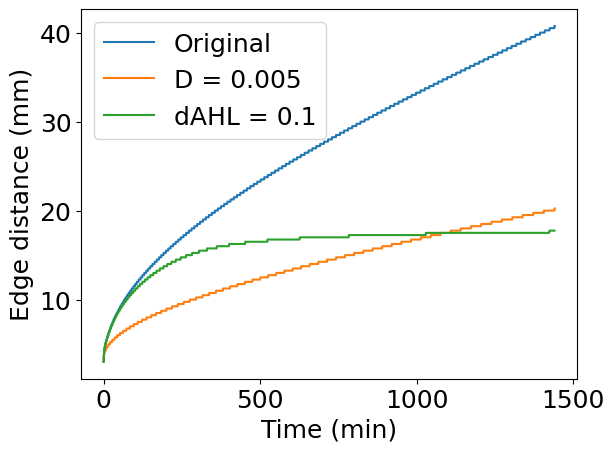

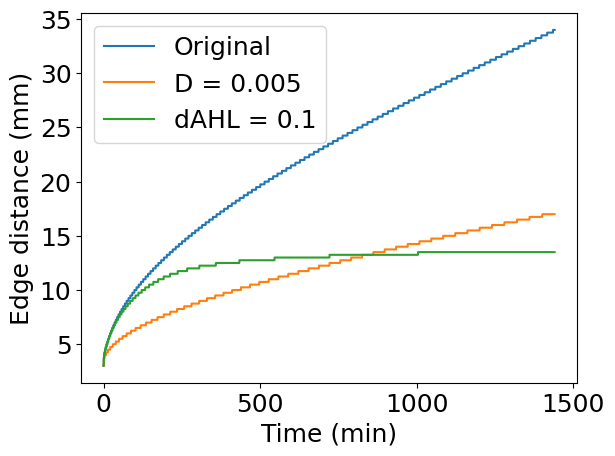

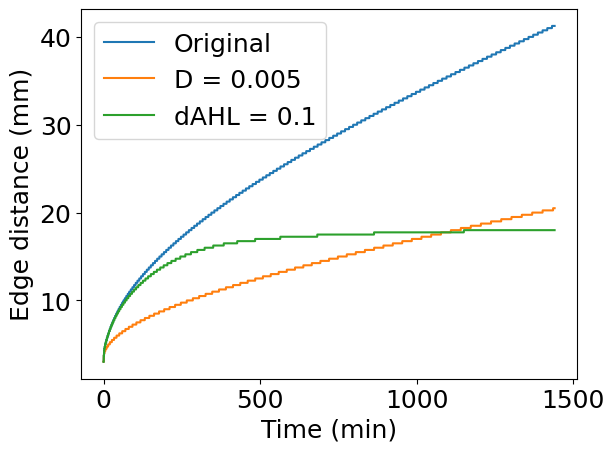

In [203]:
# See how changing the parameters affects the model
D_init = 0.025
dAHL_init = 0

D_scaled = 0.005
dAHL_scaled = 0.1

# Original model:
edge_distances_GFP = model_2d_diffusion(AHL_Initial, D_init, dAHL_init)

# Scaled model:
edge_distances_GFP_1 = model_2d_diffusion(AHL_Initial, D_scaled, dAHL_init)

# Scaled model:
edge_distances_GFP_2 = model_2d_diffusion(AHL_Initial, D_init, dAHL_scaled)

# set outlier to radius
for i in range(len(edge_distances_GFP_1)):
    for j in range(len(edge_distances_GFP_1[i])//10):
        if edge_distances_GFP[i][j] >= Radius_Plate:
            edge_distances_GFP[i][j] = Radius_Disk
        if edge_distances_GFP_1[i][j] >= Radius_Plate:
            edge_distances_GFP_1[i][j] = Radius_Disk
        if edge_distances_GFP_2[i][j] >= Radius_Plate:
            edge_distances_GFP_2[i][j] = Radius_Disk

# Plot the edge distances over time for all strains
plt.figure()
plt.plot(time, edge_distances_GFP[0], label='Original')
plt.plot(time, edge_distances_GFP_1[0], label='D = 0.005')
plt.plot(time, edge_distances_GFP_2[0], label='dAHL = 0.1')
plt.xlabel('Time (min)')
plt.ylabel('Edge distance (mm)')
plt.legend()
plt.show()

plt.figure()
plt.plot(time, edge_distances_GFP[1], label='Original')
plt.plot(time, edge_distances_GFP_1[1], label='D = 0.005')
plt.plot(time, edge_distances_GFP_2[1], label='dAHL = 0.1')
plt.xlabel('Time (min)')
plt.ylabel('Edge distance (mm)')
plt.legend()
plt.show()

plt.figure()
plt.plot(time, edge_distances_GFP[2], label='Original')
plt.plot(time, edge_distances_GFP_1[2], label='D = 0.005')
plt.plot(time, edge_distances_GFP_2[2], label='dAHL = 0.1')
plt.xlabel('Time (min)')
plt.ylabel('Edge distance (mm)')
plt.legend()
plt.show()